**MLP классификатор** 

Евгений Борисов  <esborisov@sevsu.ru>

In [2]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [3]:
np.set_printoptions(precision=2)

## генерируем данные

In [4]:
n_samples = 500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=n_samples, noise=.09)

from sklearn.datasets import make_circles
X,target = make_circles(n_samples=n_samples, shuffle=True, noise=.09, factor=.3)
# X = X+(np.random.rand(X.shape[0],X.shape[1])*0.6)


y = np.eye(len(target),2)[target] # [:,np.newaxis]

X.shape, y.shape

((500, 2), (500, 2))

In [5]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [6]:
# np.percentile(X,[10,25,50,75,95],axis=0) 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250, 2), (250, 2), (250, 2))

In [8]:
del X
del y
del target

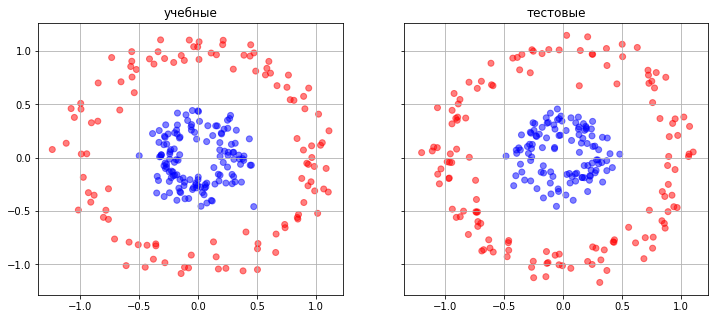

In [9]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.astype(int).flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train[:,0],'учебные')    
plot_data(ax1,X_test,y_test[:,0],'тестовые')    
plt.show()

In [10]:
# from sklearn.preprocessing import PolynomialFeatures

# poly_degree = 1 # степень полинома

# # собираем полином, добавляем столбец из единиц (свободный член)
# poly = PolynomialFeatures(poly_degree).fit(X_train)
# Xp = poly.transform(X_train)
# Xp.shape

## модель

In [11]:
def state(x,w,b): # состояние нейронов слоя
    return x.dot(w) + b

In [12]:
def sigmoid(u): # функция активации
    return 1./(1. + np.exp(-u))

act = sigmoid

In [13]:
def diff_sigmoid(u): # производная активации
    return ( np.square(sigmoid(u))*np.exp(-u) )
diff_act = diff_sigmoid

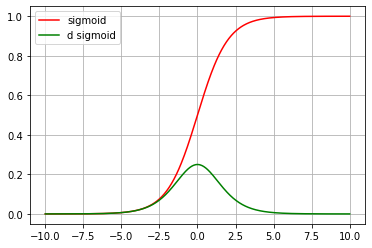

In [14]:
u=np.linspace(-10,10,500)
plt.plot( u,act(u),'-r', label='sigmoid' )
plt.plot( u,diff_act(u),'-g', label='d sigmoid' )
plt.grid()
plt.legend()

In [15]:
def layer(x,w,b): # выход слоя
    return act(state(x,w,b))

In [16]:
# def layer_partial(x,w,b ): # частные производные слоя по его аргументам
#     return diff_act( state(x,w,b) )*x

In [17]:
def model(x,W): # выход модели
    o = x
    for w,b in W: o = layer(o,w,b)
    return o 

In [18]:
def model_partial(x,W): # выход модели
    p = []
    o = x
    for w,b in W: 
        s = state(o,w,b)
        p.append( o.T.dot(diff_act(s)) )
        o = act(s)
    return p

---

In [19]:
model_size = [ X_train.shape[1],10,10, y_train.shape[1] ]

def init_weight(model_size):
    return  [ 
        [ rng.normal(size=model_size[i:i+2],scale=.1), np.zeros(model_size[i+1]) ] 
         for i in range(len(model_size)-1)
        ]

W = init_weight(model_size)
[ [ w[0].shape,w[1].shape] for w in W]

[[(2, 10), (10,)], [(10, 10), (10,)], [(10, 2), (2,)]]

In [20]:
# model(X_train,W)

In [21]:
# [ p.shape  for p in model_partial(X_train,W) ]

In [22]:
# import graphviz
# dot = graphviz.Digraph()
# dot.attr(size='6,7')

# layer = []
# l=0
# for n in range(model_size[0]):
#     node=f'{l}-{n}'
#     dot.node(node,f'{n}')
#     layer.append(node)

# for l,s in enumerate(model_size[1:],1):
#     layer_prev = layer.copy()
#     layer=[]
#     for n in range(s):
#         node=f'{l}-{n}'
#         dot.node(node,f'{n}')
#         for lp in layer_prev: dot.edge(lp,node)        
#         layer.append(node)

# dot        

---

## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [23]:
def msqe(y,o): # средняя квадратичная ошибка
    d = o-y 
    return np.square(d).sum()/(len(y)*y.shape[1])

loss = msqe

In [24]:
msqe(y_train,model(X_train,W))

0.24812378031932975

---

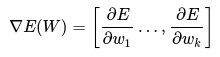

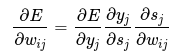

частные производные функции потери по параметрам модели (градиент)

$$ \frac{\partial E }{\partial w} = 2 \cdot( o - y ) \cdot \frac{\partial o }{\partial w}  $$

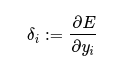

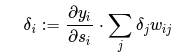

In [25]:
# list(range(9))[:0:-1]

In [26]:
def back_prop(d,W): 
    bp = [ d ]
    for w,_ in W[:0:-1]: bp.append( diff_act( bp[-1].dot(w.T) ) )
    return [ d.sum(axis=0)[np.newaxis,:] for d in bp[::-1] ]

# d = model(X_train,W)-y_train
# bp = back_prop(d,W) # [ (250, 10), (250, 2)]
# [ b.shape for b in bp ]
# model_partial(X_train,W) # [(2, 10), (10, 2)]

In [49]:
# [ [a,b,c] for a,b,c in zip([1,2,3],[4,5,6],[7,8,9]) ]

In [55]:
# rng.normal(size=3).amax

In [56]:
def msqe_partial(x,W,y): # градиент функции потери,
    d = model(x,W)-y
    bp = back_prop(d,W)
    mp = model_partial(x,W)
    g = [ [p*b,b] for b,p in zip(bp,mp) ]  # градиент msqe
    
    # нормируем градиент
    g_max = [ max(np.abs(w).max(),np.abs(b).max()) for w,b in g ] 
    g = [ ([ w/gm, b/gm ] if gm>0. else [w,b] ) for (w,b),gm in zip(g,g_max) ] 
    return g

gradient = msqe_partial

# [ [w.shape,b.shape] for w,b in msqe_partial(X_train,W,y_train) ]

# msqe_partial(X_train,W,y_train) 

---

In [57]:
def weight_adjust(w,g,lr):
    return [ [ w - lr*gw, b - lr*gb  ] for (w,b),(gw,gb) in zip(w,g)  ]  # корректируем параметры

In [58]:
def fit_epoch(x,y,w,lr): # шаг обучения модели
    g = gradient(x,w,y) # градиент функции потери, изменение весов
    return weight_adjust(w,g,lr) # корректируем параметры

In [59]:
from sklearn.metrics import accuracy_score

In [60]:
W = init_weight(model_size)

In [66]:
%%time

# метод градиентного спуска

lr = 1e-3 # скорость обучени
n_samples = len(y_train) # количество примеров
n_epoch = 170 # максимальное число циклов обучения
acc_min = .98 # порог минимально допустимой погрешности модели
n_param = X_train.shape[1] # размер вектора признаков

# инициализация параметров модели
w = rng.normal(size=(n_param))
#w = np.array( [0] + [1]*(n_param-1) )

# начальное значение ф-ции потери
loss_history = [ loss(y_train,model(X_train,W)) ]
acc_history = [ accuracy_score( y_train[:,1].astype(int), (model(X_train,W)[:,1]>.5).astype(int) ) ]

for i in range(n_epoch): # цикл обучения
    W = fit_epoch(X_train,y_train,W,lr) # корректируем веса модели
    loss_history.append( loss(y_train,model(X_train,W)) ) # считаем значение ф-ции потери
    acc_history.append( accuracy_score( y_train[:,1].astype(int) , (model(X_train,W)[:,1]>.5).astype(int) ) )
    
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(i+1,n_epoch,loss_history[-1],acc_min))
        break

CPU times: user 113 ms, sys: 0 ns, total: 113 ms
Wall time: 112 ms


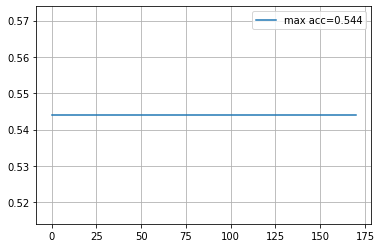

In [67]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)))
plt.grid()
plt.legend()

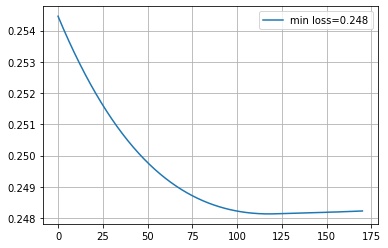

In [63]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

In [65]:
# W

## тестируем модель

In [ ]:
s = model(X_test,W)[:,1]

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test[:,1], s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

In [ ]:
p = (s>optimal_threshold).astype(int)
y = y_test[:,1].astype(int)

In [ ]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

## карта скоров

In [ ]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-.1, X_test[:,0].max()+.1, n), 
    np.linspace( X_test[:,1].min()-.1, X_test[:,1].max()+.1, n)
) # узлы сетки

xy = np.vstack([xx.flatten(),yy.flatten() ]).T # разворачиваем сетку 

s = model(xy,W)[:,1]

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test[:,1].astype(int), alpha=.5 )
plt.grid()

In [ ]:
# % - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# function retval=mlp_grad(l,er,cfg),
#    ltp = 2 ; % номер ячейки cfg с типом ф-ции активации
#    g = {} ; % градиент ошибки сети
   
#    for j=1:length(er),
#       o = mlp_activate(l{j},cfg{j}{ltp})  ;
# 	  g{j}{1} = er{j}*o' ; 
# 	  g{j}{2} = sum(er{j},2) ;
#    endfor


#    retval=g;

# endfunction

# % - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# function retval=mlp_errors(l,y,W,cfg),
#    ltp=2; % номер ячейки cfg с типом ф-ции активации
#    layers_numb = length(cfg) ; % количество слоёв сети, включая вход
 
#    er = {} ; % ошибка слоёв
  
#    er{layers_numb-1} = mlp_loss_drvt( l{end}, y, cfg ) ; % ошибка сети (выходного слоя)
  
#    for j=layers_numb-2:-1:1, % ошибки скрытых слоёв
# 	  df = mlp_activate_drvt( l{j+1}, cfg{j+1}{ltp} ) ; % значения производной ф-ции активации 
# 	  er{j} = ( (W{j+1}{1})' * er{j+1} ) .* df ; % ошибка слоя j
#    endfor

#    retval=er;
# endfunction
